In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

In [22]:
data = pd.read_csv('data.csv')
data = data.drop(['id','Unnamed: 32'], axis = 1) # удаляем идентификаторы пациентов и пустой столбец

names_of_cols = ['radius', 'texture', 
                 'perimeter', 'area', 
                 'smoothness', 'compactness', 
                 'concavity', 'concave points',
                 'symmetry', 'fractal_dimension']
data = data.replace({'diagnosis':{'M':1, 'B':0}})
data['diagnosis'] = pd.to_numeric(data['diagnosis'])

Много линейно-зависимых столбцов


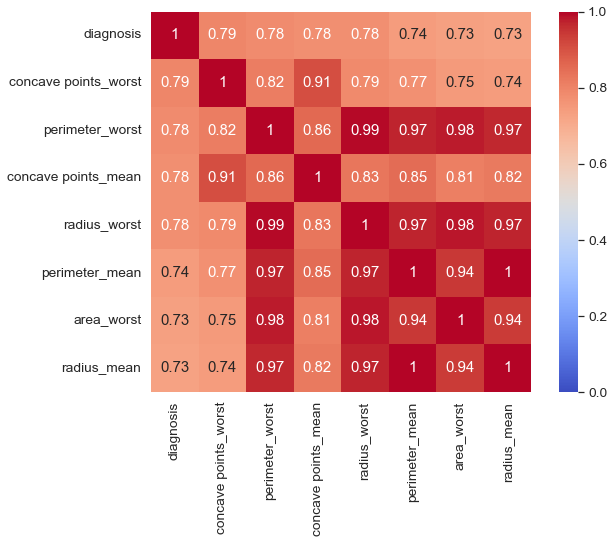

In [23]:
# Оценка признаков на линейную независимость
k = 8
corr = data.corr()
cols = corr.nlargest(k, 'diagnosis')['diagnosis'].index.tolist()
cm = np.corrcoef(data[cols].values.T)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.25)
sns.heatmap(cm, yticklabels=cols, xticklabels=cols, 
            square=True, annot=True, 
            cmap=sns.color_palette('coolwarm', 1000), vmin=0, center=0.5)
print('Много линейно-зависимых столбцов')
plt.show()

## Preprocessing
Понятно, что радиус, площадь и периметр очень сильно коррелируют между собой(поэтому оставим один из них), также преобразуем признаки путём усреднения feature_mean и feature_worst между собой. Признаки типа feature_se попробуем отбросить.

In [24]:
for name in names_of_cols:
    data[name] = sum(data[name + '_mean'], data[name + '_worst'])/2
    data.drop(columns=name + '_mean', axis=1, inplace=True) # дропнем ненужные признаки
    data.drop(columns=name + '_worst', axis=1, inplace=True)
    data.drop(columns=name + '_se', axis=1, inplace=True)
    
data.drop(columns=['radius', 'perimeter'], axis=1, inplace=True)

In [25]:
data = data.replace({'diagnosis':{'M':1, 'B':0}})
data['diagnosis'] = pd.to_numeric(data['diagnosis'])
k = 6
corr = data.corr()

# 6 наиболее скореллированных признаков с целевой переменной
cols = corr.nlargest(k, 'diagnosis')['diagnosis'].index.tolist()

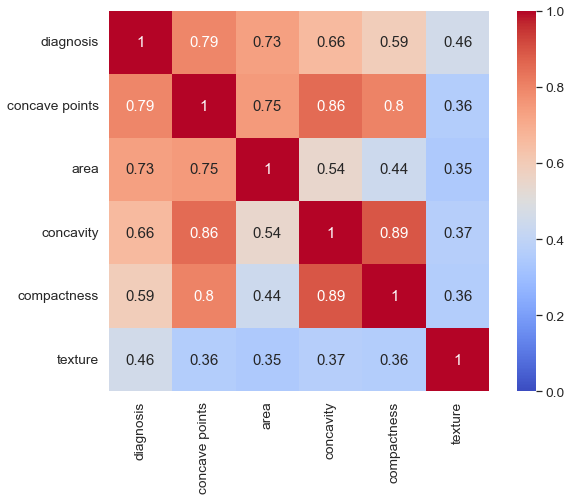

In [26]:
cm = np.corrcoef(data[cols].values.T)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.25)
sns.heatmap(cm, yticklabels=cols, xticklabels=cols, 
            square=True, annot=True, 
            cmap=sns.color_palette('coolwarm', 1000), vmin=0, center=0.5)
plt.show()

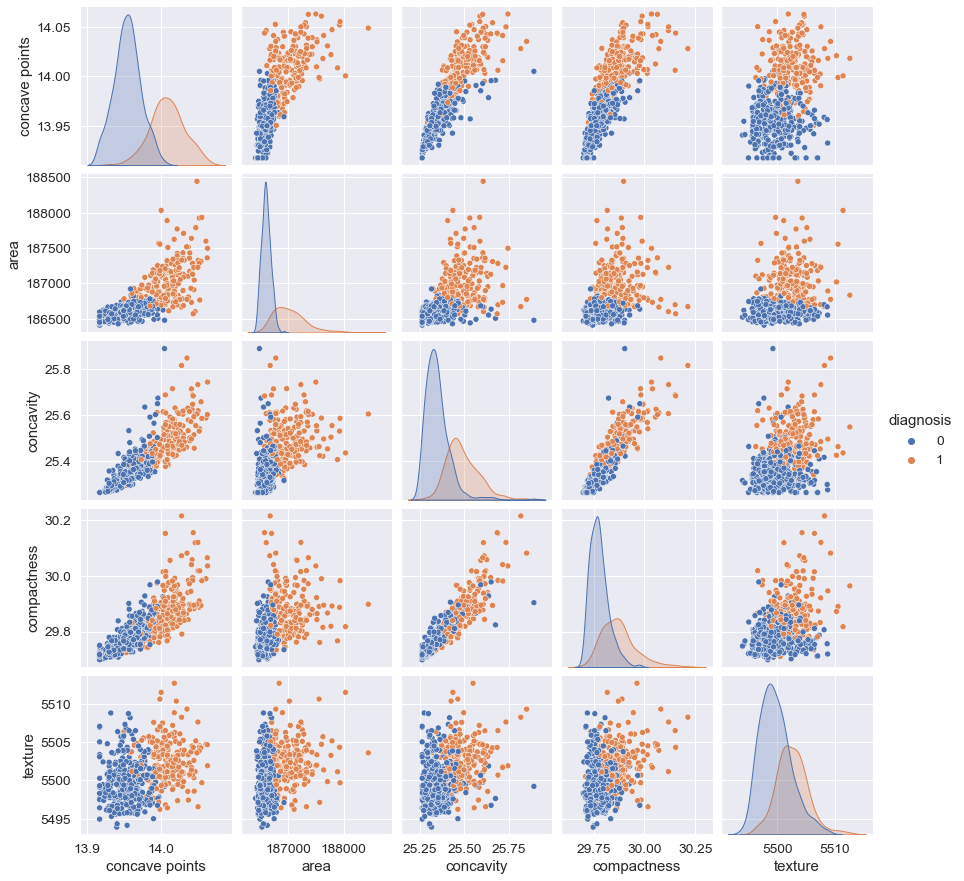

In [27]:
sns.pairplot(data[cols], hue='diagnosis')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, 'texture':], data['diagnosis'], 
                                                    test_size=0.3, stratify=data['diagnosis'], 
                                                    random_state=42)
# Отмасштабируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Best accuracy 
0.971 
K = 3 

Best precision 
0.974 
K = 3 

Best recall 
0.964 
K = 3 

Best fscore 
0.968 
K = 3 


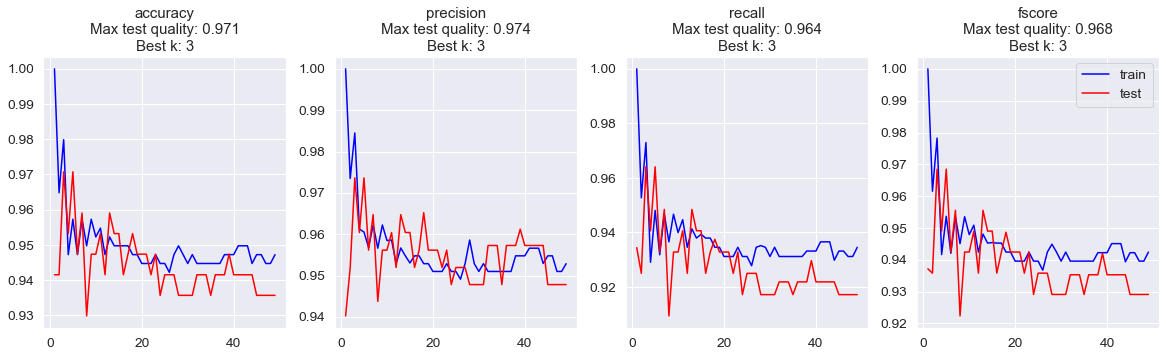

In [29]:
neighbors = range(1, 50)

def predict_and_write_metrics(model, X, y, k, report):
    y_pred = model.predict(X)
    scorings = precision_recall_fscore_support(y, y_pred, average='macro')
    accuracy = accuracy_score(y, y_pred)
    report['accuracy'].append(accuracy)
    report['precision'].append(scorings[0])
    report['recall'].append(scorings[1])
    report['fscore'].append(scorings[2])
    report['k'].append(k)

report_train = {'accuracy':[], 'precision':[],'recall':[],'fscore':[],'k':[]}
report_test = {'accuracy':[], 'precision':[],'recall':[],'fscore':[],'k':[]}


# Наивный перебор соседей и оценка метрик
for k in neighbors: 
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train.ravel())
    
    predict_and_write_metrics(knn, X_train, y_train, k, report_train)
    predict_and_write_metrics(knn, X_test, y_test, k, report_test)

report_train = pd.DataFrame(report_train)
report_test = pd.DataFrame(report_test)

# Отображение "лучших" метрик качества и кол-во соседей для них
for col in report_test.columns[:-1]:
    print('\nBest', col,'\n{:.3f}'.format(report_test.iloc[report_test[col].argmax()][col]) ,
            '\nK =', int(report_test.iloc[report_test[col].argmax()]['k']), "\n" + "==" * 20)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

# Отображение измения качества на трейне и тесте для разных метрик качества
for i, col in enumerate(report_test.columns[:-1]):
    axs[i].plot(neighbors, report_train[col], color='blue', label='train')
    axs[i].plot(neighbors, report_test[col], color='red', label='test')
    axs[i].title.set_text(col + "\nMax test quality: {:.3f}\nBest k: {}".format(max(report_test[col]), 
                                                            int(report_test.iloc[report_test[col].argmax()]['k'])))
plt.legend()
plt.show()

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
        'n_neighbors': range(1, 50)
}

knn = KNeighborsClassifier()



# на основе какого скоринга будут отбираться лучшие параметры при GridSearch'е
scores = ['accuracy', 'precision', 'recall', 'f1'] 

for score in scores:
    print(10 * "==" + f" Подбор гиперпараметров для {score}" + 10 * "==")
    print()

    clf = GridSearchCV(knn, param_grid, cv=5, scoring=score)
    clf.fit(X_train, y_train.ravel())
    
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print('\n')
    print("Метрики качества на тестовом датасете:")
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=3))
    print()

==================== Подбор гиперпараметров для accuracy====================

Best parameters set found on development set:
{'n_neighbors': 7}


Метрики качества на тестовом датасете:
              precision    recall  f1-score   support

           0      0.946     0.991     0.968       107
           1      0.983     0.906     0.943        64

    accuracy                          0.959       171
   macro avg      0.965     0.948     0.956       171
weighted avg      0.960     0.959     0.959       171


==================== Подбор гиперпараметров для precision====================

Best parameters set found on development set:
{'n_neighbors': 2}


Метрики качества на тестовом датасете:
              precision    recall  f1-score   support

           0      0.922     0.991     0.955       107
           1      0.982     0.859     0.917        64

    accuracy                          0.942       171
   macro avg      0.952     0.925     0.936       171
weighted avg      0.944     0.9

Получилось также или хуже, в отличие от наивного перебора числа соседей

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.988


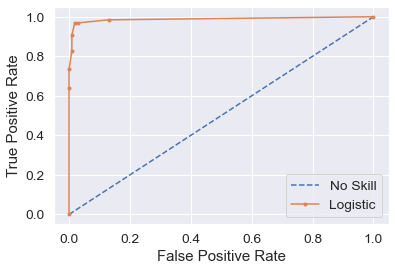

In [37]:
def build_roc(clf, X_train, y_train, X_test, y_test):
    ns_probs = [0 for _ in range(len(y_test))]
    
    clf.fit(X_train, y_train.ravel())

    lr_probs = clf.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]

    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)

    # summarize scores
    print('No Skill: ROC AUC=%.3f' % ns_auc)
    print('Logistic: ROC AUC=%.3f' % lr_auc)

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

knn = KNeighborsClassifier(n_neighbors=7)
build_roc(knn, X_train, y_train, X_test, y_test)

In [32]:
clf = LogisticRegression(random_state=729)
clf.fit(X_train, y_train.ravel())
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.973     1.000     0.986       107
           1      1.000     0.953     0.976        64

    accuracy                          0.982       171
   macro avg      0.986     0.977     0.981       171
weighted avg      0.983     0.982     0.982       171



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.998


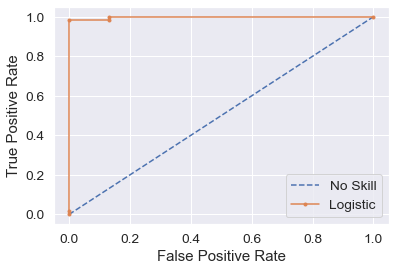

In [35]:
logit_clf = LogisticRegression(random_state=729)
build_roc(logit_clf, X_train, y_train, X_test, y_test)